Sampling n-dimensional distributions that have multiple peaks in the posterior distribution with a standard Metropolis-Hastings algorithm can be very difficult- if not even impossible, as the Markov Chain often gets stuck in either of the minima.

This problem can be avoided by running many (n_chains) Markov Chains in parallel for (n_steps) steps. To speed this process up we do not sample right away from the posterior distribution, but rather from an intermediate distribution that is similar to the previous distribution. Once the sampling for all the chains is finished, the algorithm enters a 'transitional stage'.

In this stage the similarity between the intermediate distributions is evaluated by a tempering parameter (beta), which is autmatically determined from the sampling results (coefficient of variation[COV]) from the previous intermediate distribution. If the COV is high the cooling is slow, resulting in small steps in beta and vice versa.
Also based on the parameter distributions the MultivariateProposal is updated and new seed points for the following Markov Chains are determined. The end points of the Markov Chains with the highest likelihoods are chosen as new seed-points for the Markov Chains of the next sampling stage.

So the sampling of the intermediate distribution is repeated until beta > 1., which means that finally the posterior distribution is reached.

In [8]:
import pymc3 as pm
import numpy as np
from pymc3.step_methods import smc
import theano.tensor as tt
from matplotlib import pyplot as plt
from tempfile import mkdtemp
import shutil
%matplotlib inline

test_folder = mkdtemp(prefix='ATMIP_TEST')

The number of Markov Chains and the number of steps each Markov Chain is sampling has to be defined. As well as the tune_interval and the number of processors to be used in the parallel sampling. In this very simple example using only one processor is faster than forking the interpreter. However, if the calculation cost of the model increases it becomes more efficient to use many processors.

In [9]:
n_chains = 500
n_steps = 100
tune_interval = 25
n_jobs = 1

Define the number of dimensions for the Multivariate Gaussians, their weights and the covariance matrix. 

In [10]:
n = 4

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = stdev
w2 = (1 - stdev)


The pymc3 Model:

In [11]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return tt.log(w1 * tt.exp(log_like1) + w2 * tt.exp(log_like2))


with pm.Model() as ATMIP_test:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1),
                   transform=None)
    like = pm.Deterministic('like', two_gaussians(X))
    llk = pm.Potential('like', like)

Note: In contrast to other pymc3 samplers here we have to define a random variable 'like' that contains the model likelihood. As the likelihood has to be stored in the sampling traces aloong with the model parameter samples, in order to determine the coefficient of variation [COV] in each transition stage.

Now the sampler is initialised dependent on the previous specifications. 

In [12]:
with ATMIP_test:
    step = smc.SMC(
        n_chains=n_chains, tune_interval=tune_interval,
        likelihood_name=ATMIP_test.deterministics[0].name)

Finally, the sampling is executed.

In [13]:
mtrace = smc.ATMIP_sample(
    n_steps=n_steps,
    step=step,
    n_jobs=n_jobs,
    progressbar=False,
    stage='0',
    homepath=test_folder,
    model=ATMIP_test,
    rm_flag=True)

124750it [00:00, 1077799.71it/s]
124750it [00:08, 28052.58it/s]
124750it [00:08, 14703.71it/s]
124750it [00:08, 14459.77it/s]
124750it [00:08, 28864.58it/s]
124750it [00:08, 28773.98it/s]
124750it [00:08, 14463.20it/s]
124750it [00:08, 14543.98it/s]


Note: Complex models that run a long time and might for whatever reason crash during the sampling. Then the user would like to restart the sampling in the stage when the sampler stopped. This can be done by setting the stage argument to the right stage number(a string!!!). The rm_flag determines whether existing results are deleted- there is NO additional warning so far, so the user should pay attention to that one! 

Plotting the results using the traceplot.

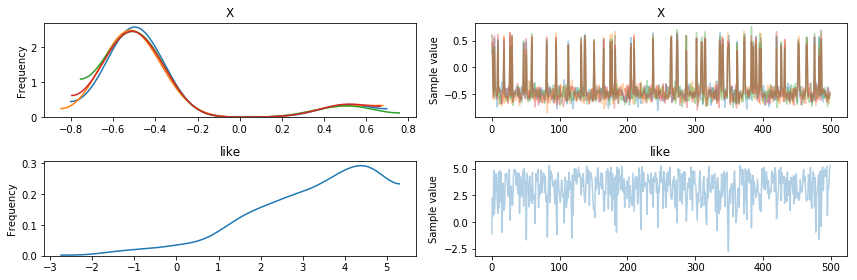

In [14]:
def last_sample(x):
    return x[(n_steps - 1)::n_steps]

axs = pm.traceplot(mtrace, transform=last_sample, combined=True)

plt.show()

Finally, we delete the sampling result folder. This folder may occupy significant disc-space (Gigabytes), depending on the number of sampling parameters for complex models. So we advice the user to check in advance if there is enough space on the disc.

In [15]:
shutil.rmtree(test_folder)